In [63]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skimage.feature import blob_dog
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage.measure import regionprops
import regions as rg
import astropy.units as u
from astropy.nddata.utils import Cutout2D
import scipy.ndimage
import sys as os

In [64]:
hdu = fits.open("./DataFiles/M82_moment2.fits") #open moment 2 map
header = hdu[0].header
imdata = hdu[0].data
print(header)
wcs = WCS(header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1400                                                  NAXIS2  =                  900                                                  BMAJ    =   5.783461938585E-04                                                  BMIN    =   4.594276793522E-04                                                  BPA     =   5.116065467813E+01                                                  BTYPE   = 'Intensity'                                                           OBJECT  = 'M82     '                                                            BUNIT   = 'km s-1  '           / Brightness (pixel) unit                        ALTRVAL =   1.151904574224E+11                                                  ALTRPIX =   8.000000000000E+01          

Set OBSGEO-B to    44.633889 from OBSGEO-[XYZ].
Set OBSGEO-H to     2556.989 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(323, 347)


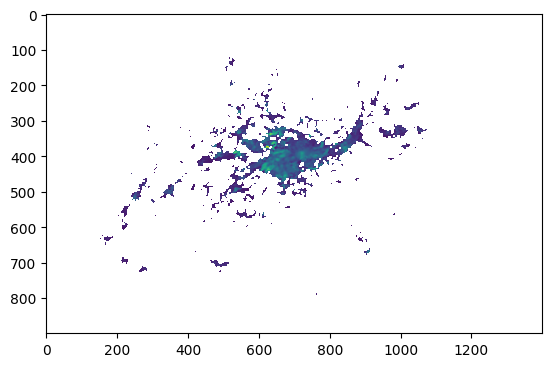

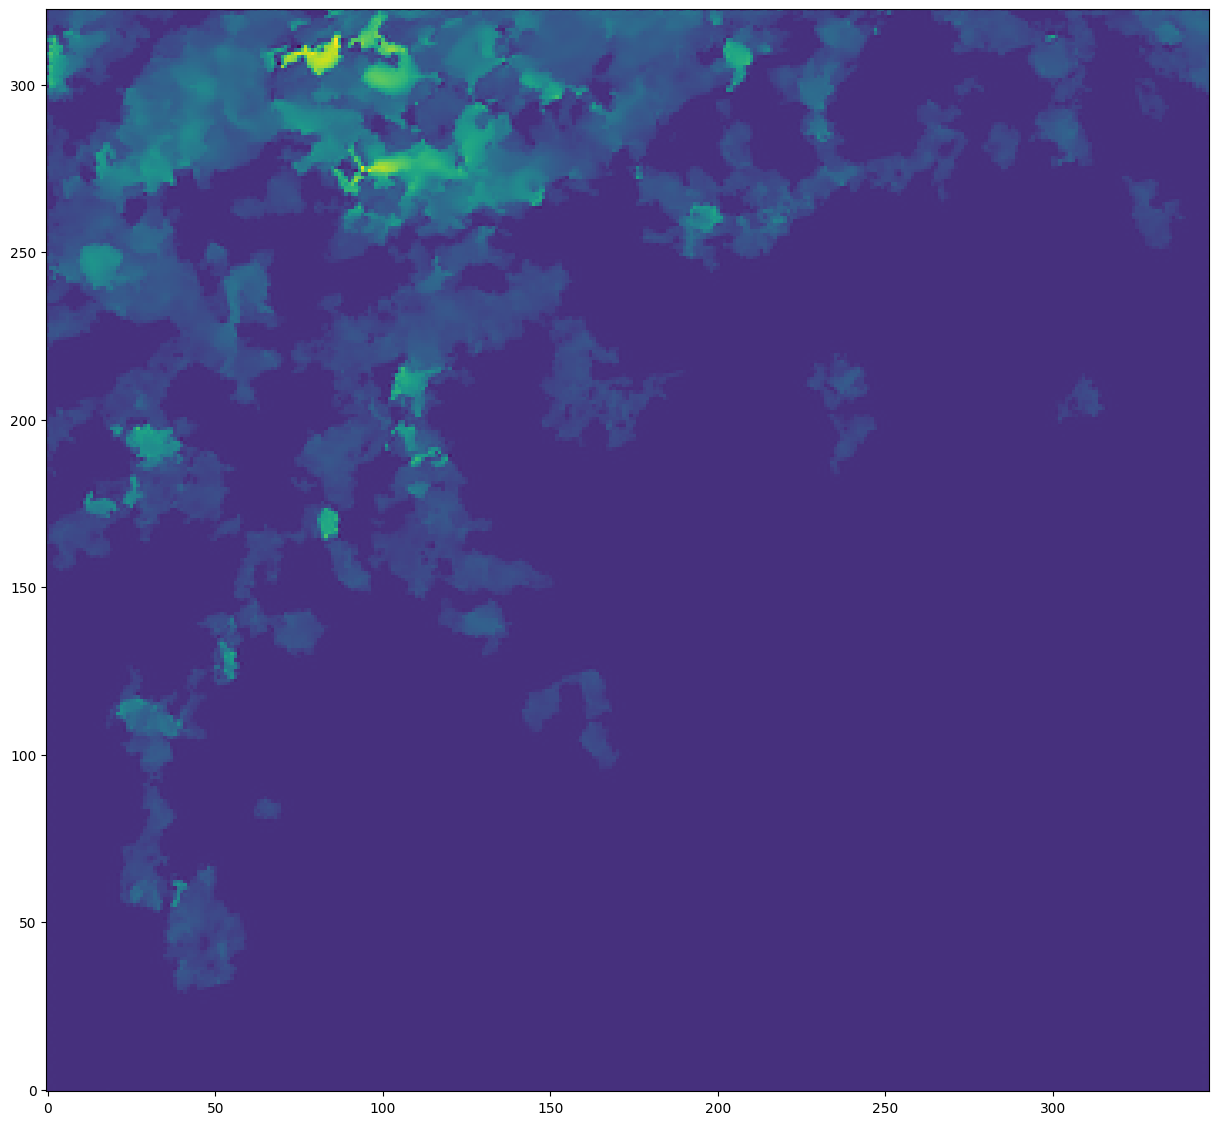

In [65]:
plt.imshow(imdata)
test_reg = rg.Regions.read('./DataFiles/M82_CO_regions.reg', format="ds9")
reg_str = ['south','north']

#for largereg,rgname in zip(test_reg,reg_str):
imdata = np.nan_to_num(imdata, nan=-1)

reg1 = test_reg[0]
mask = reg1.to_mask()
data = mask.cutout(imdata)

size = u.Quantity(data.shape, u.pixel)
cutout = Cutout2D(imdata, reg1.center.xy, size, wcs=wcs)
im_mask= mask*cutout.data

rotated_im = scipy.ndimage.rotate(im_mask, angle=-15, reshape=False)
non_zero_indecies = np.where(rotated_im > 0.1)
min_x, max_x = np.min(non_zero_indecies[1]), np.max(non_zero_indecies[1])
min_y, max_y = np.min(non_zero_indecies[0]), np.max(non_zero_indecies[0])
rotated_im = rotated_im[min_y+4:max_y-3, min_x+4:max_x-3]
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(rotated_im, origin="lower")
print(np.shape(rotated_im))

In [66]:
XORIGIN=149 #Adjusted offets for resolution
YORIGIN=323
YOFFSET=55

dist = []
disp = []

pixels = np.argwhere(rotated_im>1)
print(pixels)
for i in pixels:
    disp.append(rotated_im[i[0],i[1]])
    dpx = np.sqrt((i[1]-XORIGIN)**2+(YORIGIN-i[0]+YOFFSET)**2)
    dpc = dpx*(20/3)
    dist.append(dpc)

trueDist = np.array(dist)
trueDisp = np.array(disp)

dist = np.array(np.log10(dist))
disp = np.array(np.log10(disp))

print(disp)

[[ 29  39]
 [ 29  41]
 [ 30  39]
 ...
 [322 343]
 [322 344]
 [322 345]]
[0.30363125 0.60246354 0.95045593 ... 0.76776722 1.01017494 0.82838116]


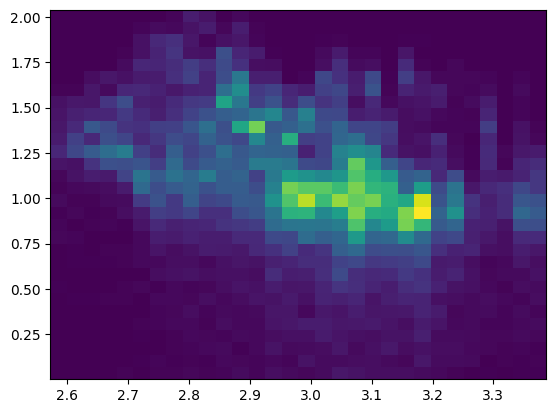

In [67]:
fig, ax = plt.subplots()
h, xbin, ybin, image = ax.hist2d(dist, disp, bins=(30,30))
def medianLine(x, y, bins):
    medianX=[]
    medianY=[]
    for i in range(np.size(bins)-1):
        lowX = bins[i]
        highX = bins[i+1]
        rangeMask = np.bitwise_and(lowX<=x, x<highX)
        medianX.append((lowX+highX)/2)
        medianY.append(np.median(y[rangeMask]))
    return medianX, medianY

def oneSigmaLine(x, y, bins):
    xOut = []
    y16 = []
    y84 = []
    for i in range(np.size(bins)-1):
        lowX = bins[i]
        highX = bins[i+1]
        rangeMask = np.bitwise_and(lowX<=x, x<highX)
        xOut.append((lowX+highX)/2)
        y16.append(np.percentile(y[rangeMask], 16))
        y84.append(np.percentile(y[rangeMask], 84))
    return xOut, y16, y84

-0.5553050006714564 2.76227094945137


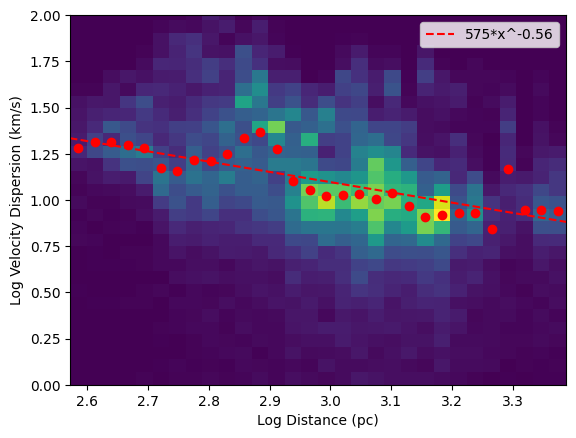

In [68]:
medX, medY = medianLine(dist, disp, xbin)
line = scipy.stats.linregress(medX, medY) #Fit line to median data
m = line.slope
b = line.intercept
lineX = np.linspace(2.5,3.4)
lineY = m*lineX+b #Calculate line to draw
fig, ax=plt.subplots()
ax.hist2d(dist, disp, bins=(30,30))
ax.scatter(medX, medY, color='red')
ax.plot(lineX, lineY, 'r--', label="575*x^-0.56")
ax.set_ylim(0, 2)
ax.set_xlabel("Log Distance (pc)")
ax.set_ylabel("Log Velocity Dispersion (km/s)") #I wouldn't give this relation much physical meaning, but it is a decent approximation
ax.legend()
print(m, b) #print slope and intercept of line in log space (legend has it converted to linear space)
#plt.savefig("VelDispersion.png")